In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import tensorflow as tf

from PIL import Image
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

import glob
import zipfile,os,shutil

In [ ]:
local_zip = "/content/drive/MyDrive/Dataset_Image/Dataset_BUSI_with_GT.zip"
# zip_ref = zipfile.ZipFile(local_zip, 'r+b')
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/test1')
zip_ref.close()

In [ ]:
masks = glob.glob("/tmp/test1/Dataset_BUSI_with_GT/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]
labels = []
for image_path in images:
    if 'benign' in image_path:
        labels.append(0)
    elif 'normal' in image_path:
        labels.append(1)
    elif 'malignant' in image_path:
        labels.append(2)

series = list(zip(images, masks, labels))

In [ ]:
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])

    f, axarr = plt.subplots(1, 3, figsize=(5, 5))

    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel(image_mask[2], fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('Citra Asli', fontsize=14)

    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')
    axarr[1].set_title('Mask', fontsize=14)

    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

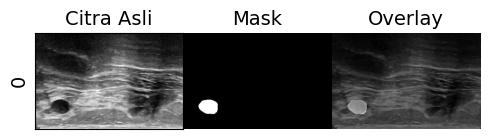

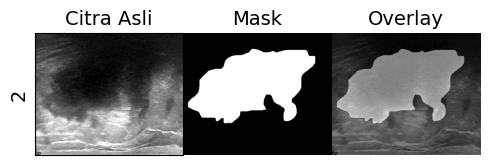

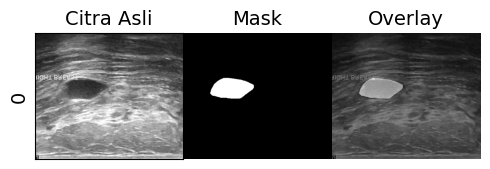

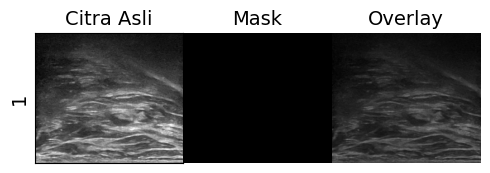

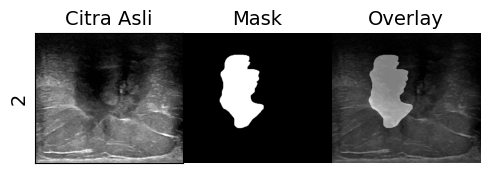

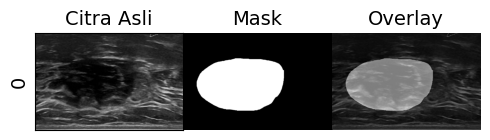

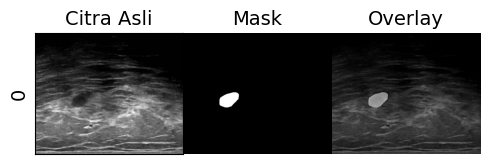

In [ ]:
random_image = random.sample(range(750), 7)
for image in random_image:
    plot_train_label(series[image])

In [ ]:
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path','labels'])

In [ ]:
dataset = dataset[['image_path','mask_path','labels']]

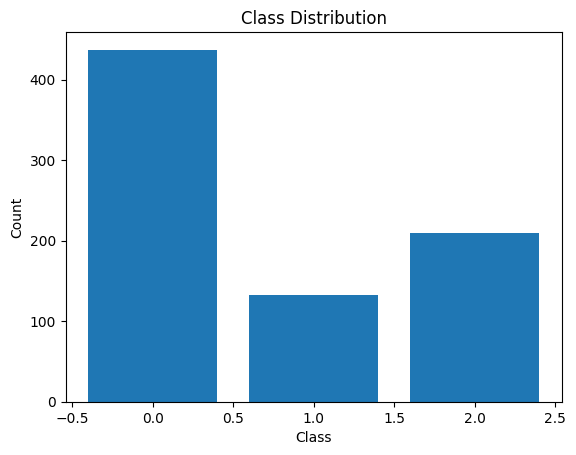

In [ ]:
class_counts = dataset['labels'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
dataset

,image_path,mask_path,labels
0,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,1
1,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,1
2,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,1
3,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,1
4,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,1
...,...,...,...
775,/tmp/test1/Dataset_BUSI_with_GT/benign/benign ...,/tmp/test1/Dataset_BUSI_with_GT/benign/benign ...,0
776,/tmp/test1/Dataset_BUSI_with_GT/benign/benign ...,/tmp/test1/Dataset_BUSI_with_GT/benign/benign ...,0
777,/tmp/test1/Dataset_BUSI_with_GT/benign/benign ...,/tmp/test1/Dataset_BUSI_with_GT/benign/benign ...,0
778,/tmp/test1/Dataset_BUSI_with_GT/benign/benign ...,/tmp/test1/Dataset_BUSI_with_GT/benign/benign ...,0


In [ ]:
aug_path = '/tmp/test1/augmented_images/'
image_paths = dataset['image_path'].values
mask_paths = dataset['mask_path'].values
# image_paths = dataset['mask_path'].values
labels = dataset['labels'].values

# Create augmented data folder if it doesn't exist
if not os.path.exists(aug_path):
    os.makedirs(aug_path)

# Count the number of samples in each class
label_counts = Counter(labels)

# Calculate the target number of samples for each class (use the maximum count)
target_count = max(label_counts.values())

# Create image augmentation transforms
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.15),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomFlip("vertical"),
])

In [ ]:
label_counts[0] - label_counts[1]

304

In [ ]:
for i in [1, 2]:
    num_augmentations = label_counts[0] - label_counts[i]
    image_paths = dataset.loc[dataset['labels'] == i, 'image_path'].values
    # image_paths = dataset.loc[dataset['labels'] == i, 'mask_path'].values
    for j in range(num_augmentations):
        random_index = random.randint(0, len(image_paths) - 1)
        image_path = image_paths[random_index]
        image = Image.open(image_path)
        image_array = np.array(image)

        # Convert image array to TensorFlow tensor
        image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)

        # Apply data augmentation
        augmented_image_tensor = data_augmentation(image_tensor)

        # Convert back to NumPy array
        augmented_image_array = augmented_image_tensor.numpy().astype(np.uint8)

        image_name = os.path.basename(image_path)
        aug_image_path = os.path.join(aug_path, f'{image_name[:-4]}.png')

        cv2.imwrite(aug_image_path, augmented_image_array)

In [ ]:
images = glob.glob("/tmp/test1/augmented_images/*.png")
# images = glob.glob("/tmp/test2/augmented_images/*/*_mask.png")
labels = []
mask_path = image_path.replace(".png", "_mask.png")
for image_path in images:
    if 'benign' in image_path:
        labels.append(0)
    elif 'normal' in image_path:
        labels.append(1)
    elif 'malignant' in image_path:
        labels.append(2)

new_series = list(zip(images,mask_path, labels))
dataset_ = pd.DataFrame(new_series, columns=['image_path','mask_path','labels'])
# new_series = list(zip(images, labels))
# dataset_ = pd.DataFrame(new_series, columns=['image_path','labels'])

In [ ]:
concatenated_df = pd.concat([dataset, dataset_], axis=0, ignore_index=True)

In [ ]:
concatenated_df

,image_path,mask_path,labels
0,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,1
1,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,1
2,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,1
3,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,1
4,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,/tmp/test1/Dataset_BUSI_with_GT/normal/normal ...,1
...,...,...,...
841,/tmp/test1/augmented_images/malignant (20).png,k,2
842,/tmp/test1/augmented_images/normal (91).png,.,1
843,/tmp/test1/augmented_images/normal (83).png,p,1
844,/tmp/test1/augmented_images/normal (72).png,n,1


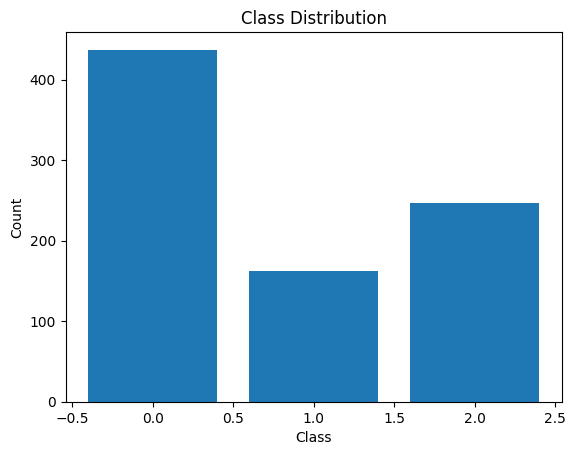

In [ ]:
class_counts = concatenated_df['labels'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
train, test= train_test_split(concatenated_df, test_size=0.3,random_state=42)
test, validation = train_test_split(test, test_size=0.3,random_state=42)

In [ ]:
class CustomImageMaskDataset(keras.utils.Sequence):
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        label = self.data.iloc[idx]['labels']

        image = Image.open(image_path).convert('RGB')

        if self.image_transform:
            image_array = np.array(image)
            image_transformed = self.image_transform(image_array.reshape(1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))
            image_transformed = image_transformed[0, :, :, :]
            image_transformed = Image.fromarray(image_transformed.astype(np.uint8))
            image = image_transformed

        return np.array(image), label

In [ ]:
image_size = 224

train_transforms = keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1./255),
])

val_transforms = keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1./255),
])


# Create datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)
val_dataset = CustomImageMaskDataset(validation, val_transforms)

# Create DataLoaders
batch_size = 32
def load_and_preprocess_image(image_path, label):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)  # Assuming 3 channels (RGB)

    # Ensure the image has a static shape
    image.set_shape([None, None, 3])

    # Resize image
    image = tf.image.resize(image, [image_size, image_size])

    return image, label

train_dataloader = tf.data.Dataset.from_tensor_slices((train_dataset.data['image_path'].values, train_dataset.data['labels'].values))
train_dataloader = train_dataloader.map(load_and_preprocess_image)
train_dataloader = train_dataloader.batch(batch_size).shuffle(buffer_size=len(train_dataset))

test_dataloader = tf.data.Dataset.from_tensor_slices((test_dataset.data['image_path'].values, test_dataset.data['labels'].values))
test_dataloader = test_dataloader.map(load_and_preprocess_image)
test_dataloader = test_dataloader.batch(batch_size)

val_dataloader = tf.data.Dataset.from_tensor_slices((val_dataset.data['image_path'].values, val_dataset.data['labels'].values))
val_dataloader = val_dataloader.map(load_and_preprocess_image)
val_dataloader = val_dataloader.batch(batch_size)

In [ ]:
for batch in train_dataloader:
    # Assuming your dataset returns a tuple (inputs, targets)
    inputs, targets = batch

    # Print the shapes
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: (32, 224, 224, 3)
Target shape: (32,)


In [ ]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    device = 'cuda'
    print("GPU Available: True")
else:
    device = 'cpu'
    print("GPU Available: False (using CPU)")

GPU Available: True


In [ ]:
class Trainer:
    def __init__(self, model, optimizer, loss_function, device='cuda'):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.device = device
        self.metrics = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    #     with tf.device(self.device):
    #         self.model.compile(optimizer=self.optimizer, loss=self.loss_function, metrics=['accuracy'])

    # def train_epoch(self, train_loader):
    #     total_loss = 0.0
    #     correct_predictions = 0
    #     total_samples = 0

    #     with tf.device(self.device):
    #         for inputs, labels in train_loader:
    #             # Train the model using .fit()
    #             history = self.model.fit(inputs, labels, batch_size=batch_size, epochs=1, verbose=0)

    #             # Update total loss and correct predictions
    #             total_loss += history.history['loss'][0]
    #             correct_predictions += history.history['accuracy'][0] * len(labels)
    #             total_samples += len(labels)

    #     epoch_loss = total_loss / len(train_loader)
    #     epoch_accuracy = correct_predictions / total_samples
    #     return epoch_loss, epoch_accuracy

        # Compile model
        self.model.compile(optimizer=self.optimizer, loss=self.loss_function, metrics=['accuracy'])

    def train_epoch(self, train_loader):
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            # Train the model using .fit()
            history = self.model.fit(inputs, labels, batch_size=batch_size, epochs=1, verbose=0)

            # Update total loss and correct predictions
            total_loss += history.history['loss'][0]
            correct_predictions += history.history['accuracy'][0] * len(labels)
            total_samples += len(labels)

        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples
        return epoch_loss, epoch_accuracy

    def evaluate(self, val_loader):
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in val_loader:
            # Evaluate the model using .evaluate()
            loss, accuracy = self.model.evaluate(inputs, labels, verbose=0)

            # Update total loss and correct predictions
            total_loss += loss
            correct_predictions += accuracy * len(labels)
            total_samples += len(labels)

        epoch_loss = total_loss / len(val_loader)
        epoch_accuracy = correct_predictions / total_samples
        return epoch_loss, epoch_accuracy

    def train(self, train_loader, val_loader, num_epochs=10):
        checkpoint = ModelCheckpoint(model_vgg16, filepath='/content/drive/MyDrive/Dataset_Image/best_model_vgg16_data_X10.h5', save_threshold=0.70)
        for epoch in range(num_epochs):
            train_loss, train_accuracy = self.train_epoch(train_loader)
            val_loss, val_accuracy = self.evaluate(val_loader)
            checkpoint(val_accuracy)

            print(f'Epoch {epoch + 1}/{num_epochs} => '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | '
                  f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

            # Save metrics
            self.metrics['train_loss'].append(train_loss)
            self.metrics['train_accuracy'].append(train_accuracy)
            self.metrics['val_loss'].append(val_loss)
            self.metrics['val_accuracy'].append(val_accuracy)

    def get_metrics(self):
        return self.metrics

In [ ]:
class ModelCheckpoint:
    def __init__(self, model, filepath='/content/drive/MyDrive/Dataset_Image/best_model_vgg16_data_X10.h5', save_threshold=0.70):
        self.model = model
        self.filepath = filepath
        self.best_accuracy = 0.0
        self.save_threshold = save_threshold

    def __call__(self, val_accuracy):
        if val_accuracy > self.best_accuracy and val_accuracy > self.save_threshold:
            self.best_accuracy = val_accuracy
            self.model.save(self.filepath)
            print(f'Saved the model with best validation accuracy: {self.best_accuracy:.4f}')

In [ ]:
def create_vgg16_model():
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])

    return model

model_vgg16 = create_vgg16_model()

models_dict = {
    model_vgg16: 'VGG16',
}

for model, name in models_dict.items():
    for layer in model.layers:
        layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    print(f'The model {name} is ready!')
    print('-'*35)

58889256/58889256 [==============================] - 3s 0us/step
The model VGG16 is ready!
-----------------------------------


In [ ]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Training and Evaluating for VGG16!
-----------------------------------
Saved the model with best validation accuracy: 0.7143
Epoch 1/10 => Train Loss: 1.1948, Train Accuracy: 0.6453 | Val Loss: 0.7257, Val Accuracy: 0.7143
Saved the model with best validation accuracy: 0.7273
Epoch 2/10 => Train Loss: 0.5412, Train Accuracy: 0.7703 | Val Loss: 0.7807, Val Accuracy: 0.7273
Saved the model with best validation accuracy: 0.7532
Epoch 3/10 => Train Loss: 0.3886, Train Accuracy: 0.8429 | Val Loss: 0.7024, Val Accuracy: 0.7532
Saved the model with best validation accuracy: 0.7922
Epoch 4/10 => Train Loss: 0.3511, Train Accuracy: 0.8767 | Val Loss: 0.6465, Val Accuracy: 0.7922
Epoch 5/10 => Train Loss: 0.2593, Train Accuracy: 0.9071 | Val Loss: 1.0190, Val Accuracy: 0.7792
Saved the model with best validation accuracy: 0.8442
Epoch 6/10 => Train Loss: 0.2315, Train Accuracy: 0.9155 | Val Loss: 0.8591, Val Accuracy: 0.8442
Epoch 7/10 => Train Loss: 0.1269, Train Accuracy: 0.9578 | Val Loss: 0.

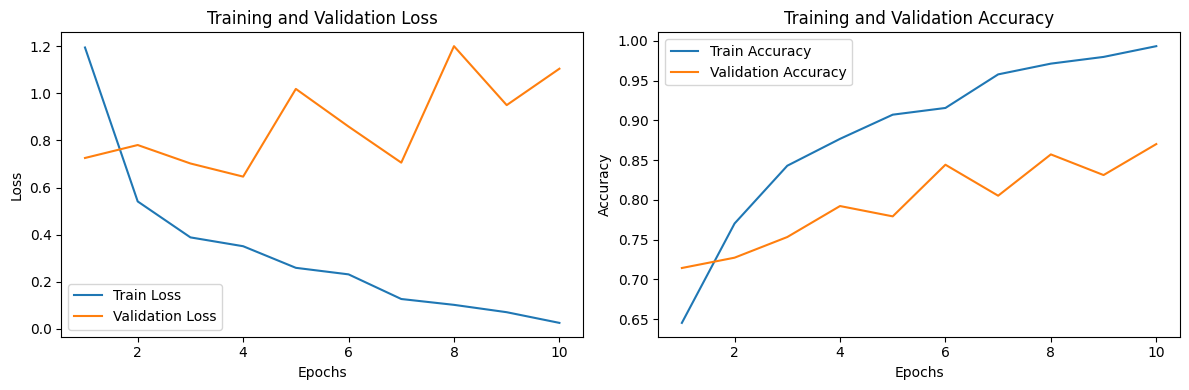

In [ ]:
for model, name in models_dict.items():
    print(f'Training and Evaluating for {name}!')
    print('-'*35)
    trainer = Trainer(model, Adam(learning_rate=0.0001), 'sparse_categorical_crossentropy')
    trainer.train(train_dataloader, val_dataloader, num_epochs=10)

    metrics = trainer.get_metrics()

    # Test on Validation Set
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in val_dataloader:
        # Convert to NumPy array if necessary
        inputs = inputs.numpy()
        labels = labels.numpy()

        # Convert to TensorFlow tensor
        inputs = tf.convert_to_tensor(inputs)
        labels = tf.convert_to_tensor(labels)

        # Forward pass
        outputs = model(inputs)

        # Get predicted labels
        predicted_labels = np.argmax(outputs.numpy(), axis=1)

        # Update correct predictions and total samples
        correct_predictions += np.sum(predicted_labels == labels.numpy())
        total_samples += labels.shape[0]

    # Calculate accuracy
    accuracy = correct_predictions / total_samples
    print(f'Val Accuracy: {accuracy * 100:.2f}%')

    # Plot metrics
    plot_metrics(metrics)

In [ ]:
train_generator = train_dataloader  # Isi dengan generator gambar Anda
classes = list(train_generator.class_indices.keys())
predicted_class_index = np.argmax(ypred)
predicted_class = classes[predicted_class_index]
print(f'Predicted class: {predicted_class}')
for class_name, class_index in train_generator.class_indices.items():
    print(f'Class: {class_name}, Index: {class_index}')

AttributeError: '_ShuffleDataset' object has no attribute 'class_indices'

1/1 [==============================] - 0s 156ms/step
Confusion Matriks:
[[33  3  2]
 [ 0 12  1]
 [ 3  1 22]]
True Positive Rate (Sensitivity): [0.86842105 0.92307692 0.84615385]
Positive Predictive Value (Precision): [0.91666667 0.75       0.88      ]
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        38
           1       0.75      0.92      0.83        13
           2       0.88      0.85      0.86        26

    accuracy                           0.87        77
   macro avg       0.85      0.88      0.86        77
weighted avg       0.88      0.87      0.87        77



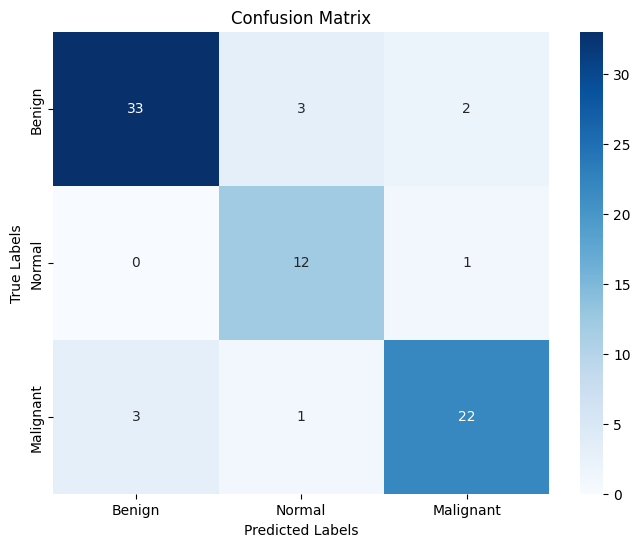

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evaluasi pada Set Validasi
prediksi_val = []
label_val = []

for inputs, labels in val_dataloader:
    inputs = inputs.numpy()  # Konversi ke array NumPy
    labels = labels.numpy()  # Konversi ke array NumPy
    hasil_prediksi = model_vgg16.predict(inputs)
    prediksi_val.extend(np.argmax(hasil_prediksi, axis=1))
    label_val.extend(labels)

# Membuat matriks kebingungan (confusion matrix)
matriks_konfusi = confusion_matrix(label_val, prediksi_val)

print("Confusion Matriks:")
print(matriks_konfusi)

# Menghitung True Positive, False Positive, False Negative
tp = np.diag(matriks_konfusi)
fp = np.sum(matriks_konfusi, axis=0) - tp
fn = np.sum(matriks_konfusi, axis=1) - tp

# Menghitung True Positive Rate (Sensitivitas atau Recall)
tpr = tp / (tp + fn)

# Menghitung Positive Predictive Value (Presisi)
ppv = tp / (tp + fp)

print("True Positive Rate (Sensitivity):", tpr)
print("Positive Predictive Value (Precision):", ppv)

# Menampilkan laporan klasifikasi
print("Laporan Klasifikasi:")
print(classification_report(label_val, prediksi_val))

# Plot matriks konfusi
plt.figure(figsize=(8, 6))
sns.heatmap(matriks_konfusi, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Normal', 'Malignant'], yticklabels=['Benign', 'Normal', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
from google.colab import files
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
from torchvision.models import resnet18
from torch import nn

%matplotlib inline


uploaded = files.upload()

for mn in uploaded.keys():

  path = mn
# ypred = model.predict(imaga)

# Memuat model yang telah dilatih
# model = load_model('/content/drive/MyDrive/Dataset_Image/best_model_vgg16_data_preprocessing_aug_1_1_2.h5')
model = load_model('/content/drive/MyDrive/Dataset_Image/best_model_vgg16_data_X10.h5')

# #kalau tidak menggunakan touchrest
# model = load_model('/content/drive/MyDrive/Dataset_Image/best_model_vgg16_data_preprocessing_aug_1.pth')

# Muat state_dict dari file .pth
# state_dict = torch.load('/content/drive/MyDrive/Dataset_Image/best_model_vgg16_data_preprocessing_aug_1.pth')

# # Muat state_dict ke model
# model.load_state_dict(state_dict)

# # Pastikan model dalam mode evaluasi
# model.eval()

# Memuat gambar yang akan diuji (ganti dengan path gambar Anda)
img = image.load_img(path, target_size=(224, 224))

# Mengonversi gambar ke array NumPy dan melakukan praproses
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Menggunakan model untuk prediksi
predictions = model.predict(img_array)

# Menampilkan hasil prediksi (misalnya, jika model menggunakan softmax)
predicted_class_index = np.argmax(predictions)

confidence = predictions[0][0] * 100

print(f'Predicted: {predictions}')

print(f'Confidence Level: {confidence}')

print(f'predicted_class_index: {predicted_class_index}')

if predicted_class_index == 0:
        class_label = 'Benign'
elif predicted_class_index == 1:
        class_label = 'Normal'
else:
        class_label = 'Malignant'

print(f'Predicted class index: {class_label}')

Saving segmentation_result.png to segmentation_result.png
1/1 [==============================] - 0s 154ms/step
Predicted: [[1. 0. 0.]]
Confidence Level: 100.0
predicted_class_index: 0
Predicted class index: Benign


1/1 [==============================] - 0s 26ms/step
Confusion Matrix:
[[30  2  9]
 [ 3 14  3]
 [ 3  8 23]]
True Positive Rate (Sensitivity): [0.73170732 0.7        0.67647059]
Positive Predictive Value (Precision): [0.83333333 0.58333333 0.65714286]


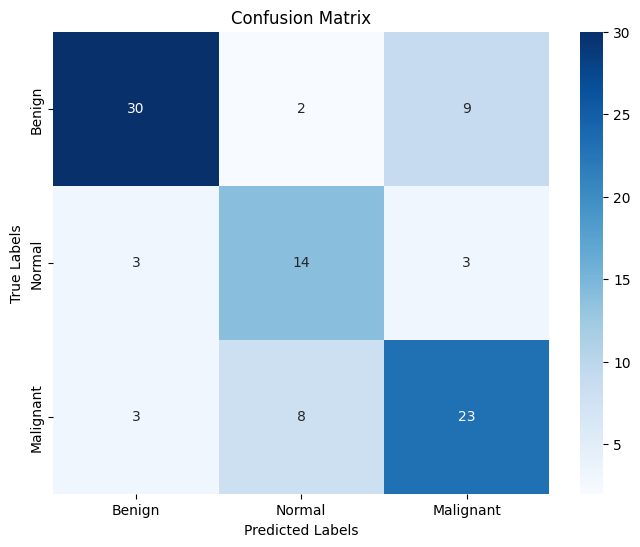

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# ...

# Train the model using .fit method
# trainer = Trainer(model_vgg16, Adam(learning_rate=0.0001), 'sparse_categorical_crossentropy')
# trainer.train(train_dataloader, val_dataloader, num_epochs=20)

# Evaluate on Validation Set
val_predictions = []
val_labels = []

for inputs, labels in val_dataloader:
    inputs = inputs.numpy()  # Convert to NumPy array
    labels = labels.numpy()  # Convert to NumPy array
    outputs = model_vgg16.predict(inputs)
    val_predictions.extend(np.argmax(outputs, axis=1))
    val_labels.extend(labels)

# Create confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)

print("Confusion Matrix:")
print(conf_matrix)

# Calculate True Positive, False Positive, False Negative
tp = np.diag(conf_matrix)
fp = np.sum(conf_matrix, axis=0) - tp
fn = np.sum(conf_matrix, axis=1) - tp

# Calculate True Positive Rate (Sensitivity or Recall)
tpr = tp / (tp + fn)

# Calculate Positive Predictive Value (Precision)
ppv = tp / (tp + fp)

print("True Positive Rate (Sensitivity):", tpr)
print("Positive Predictive Value (Precision):", ppv)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Normal', 'Malignant'], yticklabels=['Benign', 'Normal', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()